# [Exploration 13] 주식 가격 예측에 도전해 보자!

이번 프로젝트는 시계열(time series) 모델 중 하나인 ARIMA를 사용하여 특정 주식의 가격을 예측해보고자 한다.   
시계열 데이터를 활용한 미래 예측에는 다양한 통계적 계산과 이론들이 들어가 있어서 난이도가 상당히 높은 프로젝트였다.   
최대한 디테일하게 과정을 정리해보고 결과물을 창출해 보도록 하겠다.

## 데이터셋 준비

데이터셋은 **Yahoo Finance**에서 **Samsung Exlectronics Co., Ltd (005930.KS)** 주식 데이터를 다운받아 준비한다.

다운로드된 데이터셋의 디렉토리는 다음과 같이 준비한다.   
   
   
`$ mv ~/Downloads/005930.KS.csv ~/aiffel/stock_prediction/data`

## STEP 1 : 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

다음과 같이 df라는 변수에 pandas dataframe형태로 삼성전자의 주식데이터를 불러온다.   
인덱스는 Date로 주고 이후 Series형태로 불러올 때도 Date를 인덱스로 사용할 수 있다.

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


컬럼으로는 Open(시가), High(최고가), Low(최저가), Close(종가), Adj Close(수정종가), Volume(거래량)으로 나와있다.   
우리는 다음날 가격의 종가를 예측할 수 있도록 Close 컬럼값만 사용하여 시리즈 형태로 만들어 주겠다.

In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-19,82300.0,82800.0,81000.0,82600.0,82600.0,25880879.0
2021-02-22,83800.0,84200.0,82200.0,82200.0,82200.0,25419886.0
2021-02-23,81200.0,82900.0,81100.0,82000.0,82000.0,20587314.0
2021-02-24,81800.0,83600.0,81300.0,82000.0,82000.0,26807651.0
2021-02-25,84000.0,85300.0,83000.0,85100.0,85100.0,26452689.0


2021년 2월 25일 데이터까지 들어와 있다. 가장 최근 데이터까지 확인 할 수 있다.

In [5]:
ts = df['Close']
print(type(ts))
print(ts.head())

<class 'pandas.core.series.Series'>
Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64


ts를 변수로 따로 만들어 Series형태로 저장한다. Date는 인덱스이고, 값은 Close - 각 일별 종가를 나타낸다.   
가격을 보니 원화를 기준으로 데이터가 저장되어 있는 것같다.   
20년전에는 5천원대였구나...

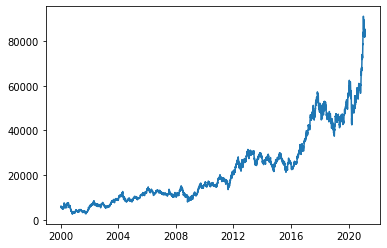

In [6]:
plt.plot(ts)

그래프는 다음과 같이 추세성을 띈다고 보여진다. Stationary한 데이터는 아니므로, 정제할 필요가 있다.

## STEP 2 : 각종 전처리 수행

데이터를 학습시키기 전에 전처리를 한다.

먼저 결측치가 있는지 확인해본다.   

In [7]:
ts[ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

총 6개의 결측치가 확인된다. 이정도는 직접 입력해줘도 되지만 `interpolate` 메서드를 사용해서 입력해보겠다.

In [8]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 사라진 것을 확인할 수 있다.

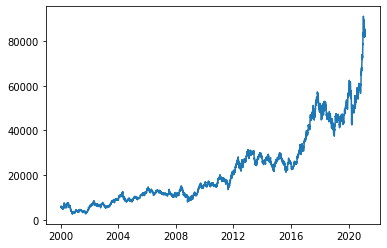

In [9]:
plt.plot(ts)

다음으로는, 추세의 분산이 줄어들 수 있도록 log변환을 해준다.

In [10]:
ts_log = np.log(ts)

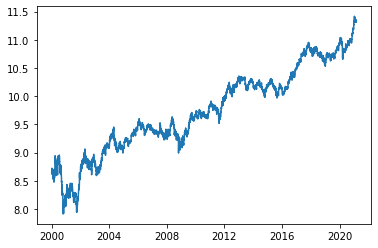

In [11]:
plt.plot(ts_log)

original 그래프 보다는 추세와 분산이 어느정도 누그러진 모습을 볼 수 있다.   
로그변환 후의 유의확률(P-value)값은 이후에 분석하여 비교해보도록 하겠다.

## STEP 3 : 시계열 안정성 분석

시계열 데이터를 분석하는데 있어서 중요한 점은 얼마나 안정적인지(Statinary)를 보는 것이다.   
안정적 시계열 데이터의 세가지 조건이 있다.   

1. 시간의 추이와 관계 없이 평균이 불변   
2. 시간의 추이와 관계 없이 분산이 불변
3. 두 시점 간의 공분산이 기준시점과 무관   
   
할 때 안정적인 시계열 데이터라고 할 수 있다.   
   
   
참고자료: http://www.dodomira.com/2016/04/21/arima_in_r/

### (1)정성적 그래프 분석

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화 하는 함수를 만든다.   
이동평균(Rolling mean)과 이동표준편차(Rolling std)를 원본 시계열 데이터와 비교하여 뚜렷한 경향성을 확인할 수 있다.

In [12]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

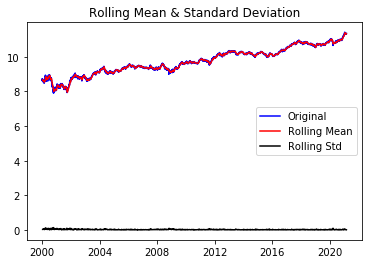

In [13]:
plot_rolling_statistics(ts_log, window=12)

데이터가 아직 추세를 가지고 있으므로 stationary한 데이터라고 말할 수 없다.   
통계적 수치를 가지고 더욱 자세히 확인해보겠다.

### (2)정량적 Augmented Dicky-Fuller Test

In [14]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Starsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 시계열 데이터의  Augmented Dickey-Fuller Test(ADF Test)를 확인해보도록 하겠다.

In [15]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                    2.509801
p-value                           0.999053
#Lags Used                       26.000000
Number of Observations Used    5290.000000
Critical Value (1%)              -3.431587
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


In [16]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.282356
p-value                           0.927966
#Lags Used                        4.000000
Number of Observations Used    5312.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


먼저 로그변환을 취하지 않았을 때의 P-value값을 보면 0.99로 안정적 시계열 데이터라고 볼 수 없다.    
이후 로그변환한 `ts_log`의 경우에도 값이 크게 낮아지지 않았으므로 안정적 시계열 데이터를 위한 전처리가 더 필요한 상태이다.

### (3) 시계열 분해 (Time Series Decomposition)

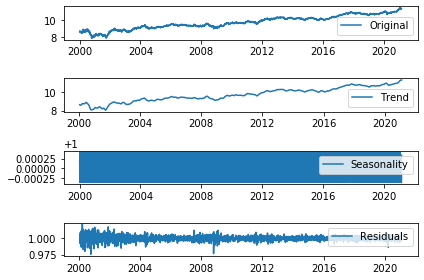

In [17]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

seasonal_decompose를 활요하여 Original을 Trend, Seasonality 그리고 Residual로 나누었다.   
여기서 Residual은 Original으로부터 Trend와 Seasonality를 제거한 형태인데, 위 그래프를 보면 가장 안정적인 시계열 데이터의 형태를 보이고 있다.   
Residual의 그래프와 adfuller값을 확인해보자.

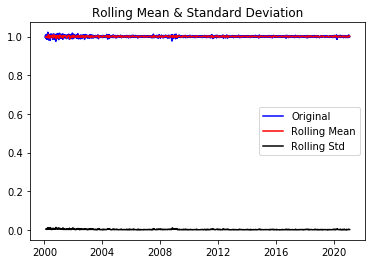

In [18]:
plot_rolling_statistics(residual)

In [19]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.759326e+01
p-value                        3.954304e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.253000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


추세와 계절성을 제거한 Residual은 상당히 안정적인 P-value값을 보인다 :)

## STEP 4 : 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

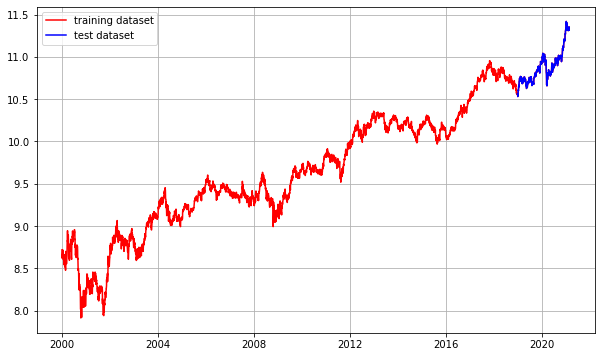

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

그래프에서 빨간색 부분은 original 데이터로, 학습시 사용할 부분이다.   
이후 파란색 부분은 모델이 예측하게될 모습이다.   
train과 test는 9:1 비율로 split하였다.

## STEP 5 : 적정 ARIMA 모수 찾기

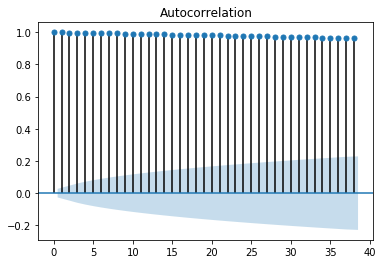

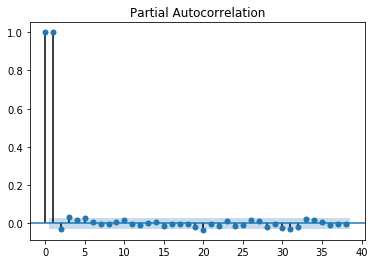

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

적정 ARIMA의 모수는 q값을 1이나 2정도로 사용하면 될것 같다.

Results of Dickey-Fuller Test:
Test Statistic                  -40.091618
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5312.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


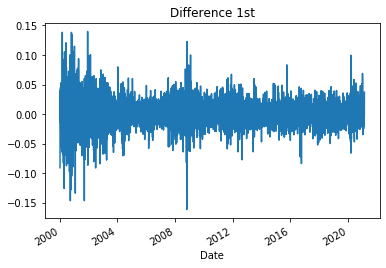

In [22]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.832250
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5281.000000
Critical Value (1%)              -3.431589
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


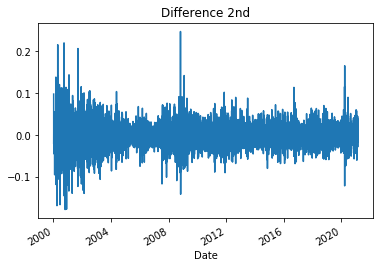

In [23]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분의 그래프와 2차 차분의 그래프가 큰 차이를 보이지 않아 어떤 값을 써야할지 애매하다.   
둘다 넣어보고 더 좋은 결과를 보이는 것으로 사용하겠다.

## STEP 6 : ARIMA 모델 훈련과 테스트

In [24]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4784
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11274.679
Method:                       css-mle   S.D. of innovations              0.023
Date:                Mon, 01 Mar 2021   AIC                         -22543.358
Time:                        22:23:14   BIC                         -22523.939
Sample:                             1   HQIC                        -22536.537
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.104      0.270      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


먼저 p와 d값을 1로 설정하였다.   
결과를 보고 이 값들을 수정해주도록 하겠다.

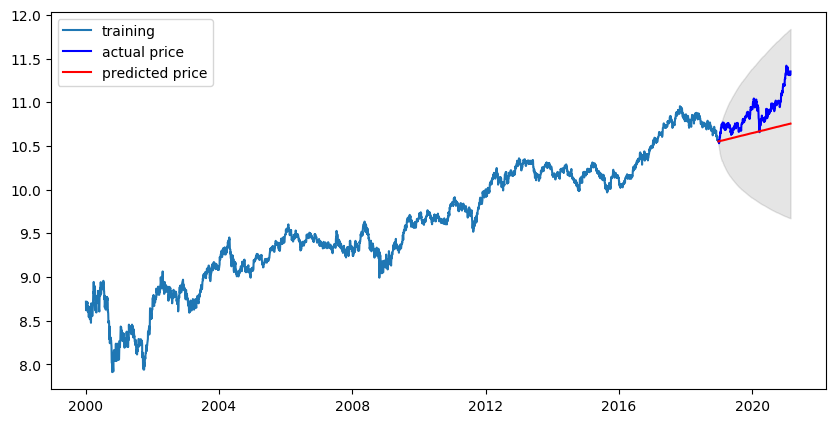

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  225482770.64059344
MAE:  11761.078884202498
RMSE:  15016.08373180549
MAPE: 19.59%


현재 그래프로 봤을 때는 좋은 예측이 나오고 있지 않다.   
MAPE값도 19% 정도로 더 낮춰야할 필요가 있다.

In [28]:
# Build Model
model = ARIMA(train_data, order=(0, 1, 2))  
fitted_m = model.fit(disp=-1)  

/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


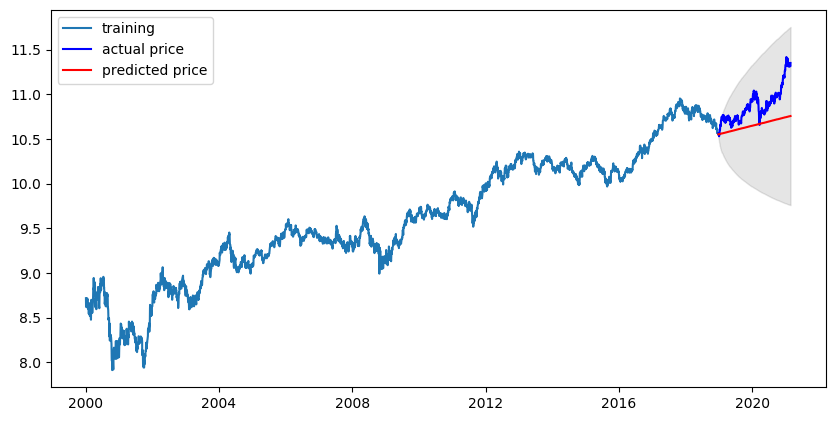

In [29]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [30]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  223718496.87678653
MAE:  11695.186017119368
RMSE:  14957.222231309746
MAPE: 19.47%


아무리 pdq 값을 바꿔봐도 낮아지지 않는다.   
다른 데이터셋으로 한번 도전해보겠다.

## Bitcoin 가격 데이터로 확인해보기!

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/BTC_USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-27,46344.773438,48253.269531,45269.027344,46188.453125,46188.453125,4.591095e+10
2021-02-28,46194.015625,46716.429688,43241.617188,45137.769531,45137.769531,5.344389e+10
2021-03-01,45159.503906,49784.015625,45115.093750,49631.242188,49631.242188,5.389130e+10
2021-03-02,49612.105469,50127.511719,47228.843750,48378.988281,48378.988281,4.753090e+10
2021-03-03,48818.574219,51752.898438,48276.386719,51357.832031,51357.832031,5.243495e+10


확실히 가격 변동성이 크게 보인다.

In [6]:
ts = df['Close']
print(type(ts))
print(ts.head())

<class 'pandas.core.series.Series'>
Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64


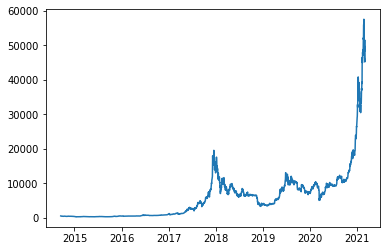

In [7]:
plt.plot(ts)

어마어마한 그래프가 보인다.   
이 이후에는 데이터를 쭉 전처리하도록 하겠다.

In [9]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [10]:
ts_log = np.log(ts)

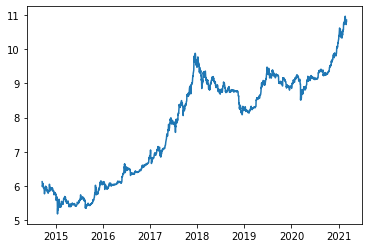

In [11]:
plt.plot(ts_log)

In [12]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

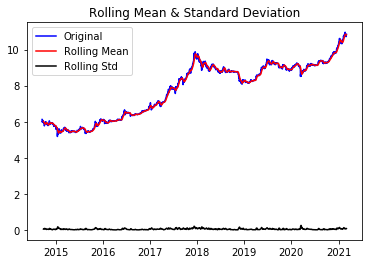

In [13]:
plot_rolling_statistics(ts_log, window=12)

In [14]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [15]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    0.323774
p-value                           0.978409
#Lags Used                       10.000000
Number of Observations Used    2349.000000
Critical Value (1%)              -3.433137
Critical Value (5%)              -2.862771
Critical Value (10%)             -2.567425
dtype: float64


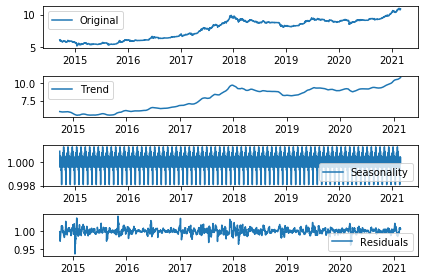

In [16]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.272752e+01
p-value                        9.530639e-24
#Lags Used                     2.700000e+01
Number of Observations Used    2.302000e+03
Critical Value (1%)           -3.433194e+00
Critical Value (5%)           -2.862796e+00
Critical Value (10%)          -2.567439e+00
dtype: float64


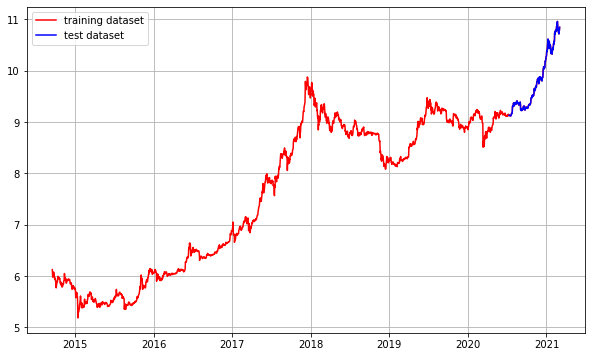

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

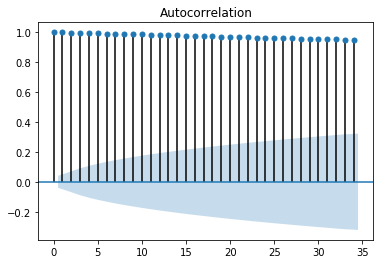

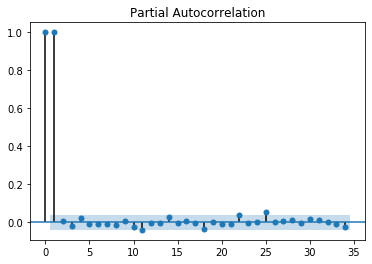

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.464740e+01
p-value                        3.544534e-27
#Lags Used                     9.000000e+00
Number of Observations Used    2.349000e+03
Critical Value (1%)           -3.433137e+00
Critical Value (5%)           -2.862771e+00
Critical Value (10%)          -2.567425e+00
dtype: float64


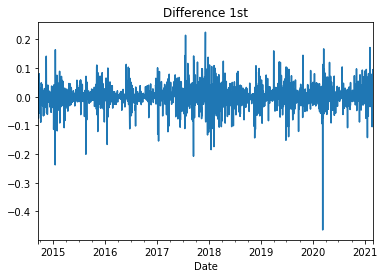

In [20]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.586783e+01
p-value                        9.054292e-29
#Lags Used                     2.500000e+01
Number of Observations Used    2.332000e+03
Critical Value (1%)           -3.433157e+00
Critical Value (5%)           -2.862780e+00
Critical Value (10%)          -2.567430e+00
dtype: float64


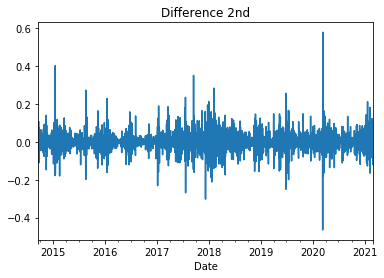

In [21]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2123
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3846.248
Method:                       css-mle   S.D. of innovations              0.040
Date:                Wed, 03 Mar 2021   AIC                          -7686.496
Time:                        20:58:26   BIC                          -7669.514
Sample:                    09-18-2014   HQIC                         -7680.279
                         - 07-10-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.682      0.093      -0.000       0.003
ar.L1.D.Close    -0.0173      0.022     -0.796      0.426      -0.060       0.025
                                    Root

/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


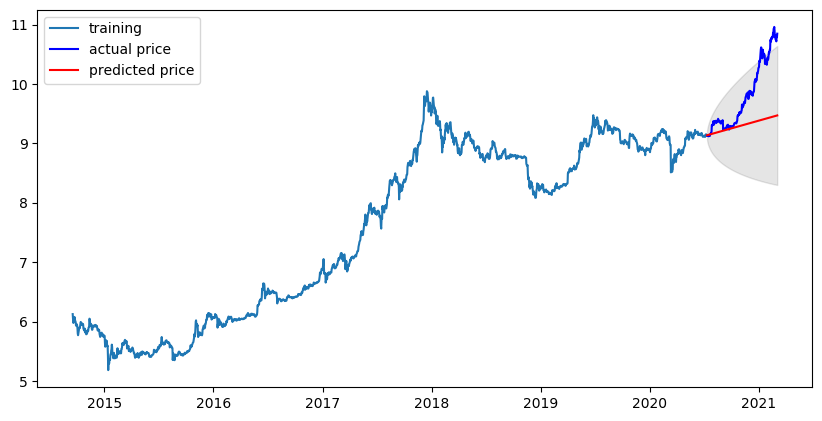

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  244542787.7542124
MAE:  9990.1757587894
RMSE:  15637.863912766743
MAPE: 32.48%


/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/aiffel-dj58/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


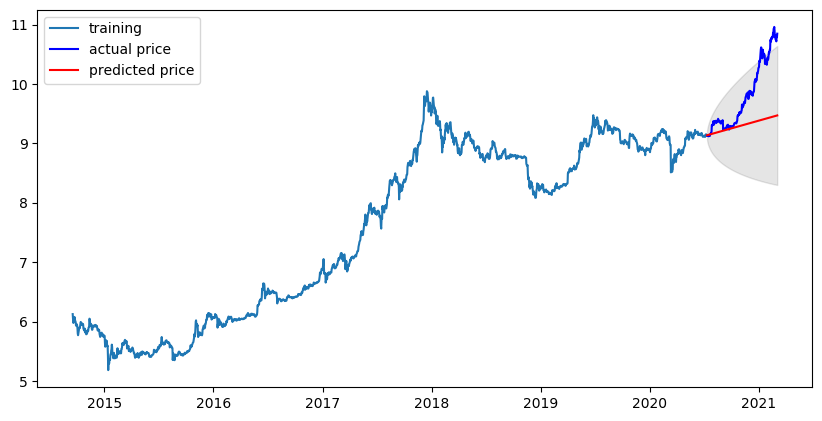

MSE:  244542787.7542124
MAE:  9990.1757587894
RMSE:  15637.863912766743
MAPE: 32.48%


In [27]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

비트코인의 경우 너무 급상승과 급하락하는 경우가 많다보니 예측하기가 더욱 힘든것 같다. 그래서 MAPE값이 다양한 경우에도 MAPE값이 생각보다 낮아지지 않는다.

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- 시계열 데이터의 특성과 ARIMA 모델에 대해 이해하는게 어려웠음   
   
   
## 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
- 저번 노드에 이어 시계열 데이터를 한번 더 다루게 되었는데 여전히 시계열 데이터를 다루는게 어렵다고 느껴진다.   
- 특히 데이터 전처리 부분은 통계적인 부분이 많다보니 더 어렵게 느껴진다.

## 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
1. 데이터 자체로는 전처리를 통하여 안정적인 P-value값을 얻을 수 있었음
2. p,q를 위한 ACF, PACF를 사용하였고 2차분 d값을 구할 수 있었음
3. 10%미만의 MAPE값을 구하지 못했지만 데이터셋을 낮추면 구할 수 있겠다는 인사이트를 배웠음

   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
- MAPE 값을 낮추지 못했다.   
- 전처리 과정을 충분히 익히지 못했다면 다른 데이터셋을 활용했을 때 학습과 결과를 충분히 제출하지 못했을것 같다.


### 5. **자기 다짐**   
시계열 데이터는 언뜻 생각하기에 간단히 예측할 수 있을것 같지만 통계적인 기법과 이해가 충분히 필요로 하는 프로젝트라 생각이 든다.   
주말을 통해서 부족한 부분을 보충하고 이해할 수 있는 시간을 가지도록 계획중이다.

   